In [1]:
%matplotlib inline

import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
sys.path.append('../../../Code/')
from utils import read_dataset_log
import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.metrics import log_loss
from scipy.stats import chi2

In [2]:
params = read_dataset_log('Dataset Paths')
params.index = params['dataset']
params

,dataset,usage_fn,gene_scores_fn,gene_tpm_fn,tcat_fn,tcat_fn_withsingletons,manual_gating_fn,manual_activation_gating_fn,activation_score_fn,metadata_fn,...,k,dt,processed_forcnmf_fn,tpm_counts_for_cnmf_fn,raw_counts_filt_fn,raw_counts_fn,dataset_type,tissue_type,context_label,tcat_fn_old
dataset,,,,,,,,,,,,,,,,,,,,,
AMP-RA,AMP-RA,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMPRA....,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMPRA....,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMPRA....,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,NaN,/data/srlab1/TCAT/Data/PerDataset/AMPRA/Manual...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/Activa...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,...,34.0,0_15,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,discovery,Synovium,RA+OA,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
Pan-Cancer,Pan-Cancer,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Pa...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Pa...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Pa...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,NaN,NaN,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Ac...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,...,38.0,0.15,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,NaN,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,discovery,Pan-Tissue,Cancer+Healthy,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
TBRU,TBRU,/data/srlab1/TCAT/Data/PerDataset/TBRU/TBRU.20...,/data/srlab1/TCAT/Data/PerDataset/TBRU/TBRU.20...,/data/srlab1/TCAT/Data/PerDataset/TBRU/TBRU.20...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,NaN,/data/srlab1/TCAT/Data/PerDataset/TBRU/ManualG...,/data/srlab1/TCAT/Data/PerDataset/TBRU/Activat...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,...,36.0,0_20,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,discovery,Blood,Healthy,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
HIV-Vaccine,HIV-Vaccine,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/HIVV...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/HIVV...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/HIVV...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/Manu...,NaN,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/Acti...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,...,31.0,0_15,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,discovery,Blood,Post-Vaccine+Healthy,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
UK-Covid,UK-Covid,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCO...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCO...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCO...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/Manu...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/Manu...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/Acti...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,...,44.0,0_20,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,NaN,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,discovery,Blood,Covid-19+Healthy,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
COMBAT,COMBAT,/data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBA...,/data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBA...,/data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBA...,/data/srlab1/TCAT/Data/TCA

In [3]:
gate_list = ['CD4_Naive', 
             'CD8_Naive', 
             'gdT',
            'MAIT', 
             'CD4_EM', 
             'CD8_EM', 
             'CD4_CM', 
             'Treg']

In [4]:
train_dir = '/data/srlab1/TCAT/Data/PerDataset/COMBAT'
test_dir =  '/data/srlab1/TCAT/Data/PerDataset/Sparks2023'

In [5]:
gep_info = read_dataset_log('cGEP_Name')
gep_info.index = gep_info['cGep_Name']
gep_info.head()

,cGep_Name,Old_Short_Name,Long_Name,Short_Name,Shortest_Name,Class,Num_Datasets,Notes,Reviewed,Filter
cGep_Name,,,,,,,,,,
COMBAT_Cytoskeleton,COMBAT_Cytoskeleton,Cytoskeleton,Actin Cytoskeleton,Cytoskeleton,Cytosk.,Functional,7.0,NaN,Y,NaN
CD8_EM,CD8_EM,CD8-EM,CD8 Effector Memory,CD8-EM,CD8-EM,Lineage,7.0,Need to confirm overlap with gating since the ...,Y,NaN
CellCycle-G2M,CellCycle-G2M,CellCycle-G2M,Cell Cycle G2M Phase,CellCycle-G2M,G2M-phase,Functional,7.0,NaN,Y,NaN
CellCycle-S,CellCycle-S,CellCycle-S,Cell Cycle S Phase,CellCycle-S,S-phase,Functional,7.0,NaN,Y,NaN
Cytotoxic,Cytotoxic,Cytotoxic,Cytotoxic,Cytotoxic,Cytotoxic,Functional,7.0,NaN,Y,NaN


In [6]:
rename_map = dict(zip(gep_info['cGep_Name'], gep_info['Short_Name']))

# Balanced multinomial prediction of lineage only using all GEPs, CD4 + CD8

## Training

In [7]:
lineage_geps = gep_info[gep_info['Class']=='Lineage']['Short_Name'].tolist()
# lineage_geps = gep_info[gep_info['Class']=='Lineage']['cGep_Name'].tolist()
lineage_geps

['CD8-EM',
 'MAIT',
 'Treg',
 'CD4-Naive',
 'TEMRA',
 'CD4-CM',
 'gdT',
 'Th22',
 'Th17-Resting',
 'Th2-Resting',
 'Th1-Like',
 'CD8-Naive',
 'CD8-Trm',
 'Tfh-2',
 'Tph',
 'Tfh-1']

In [8]:
dataset = 'COMBAT'

gating = pd.read_csv(params.loc[dataset, 'manual_gating_fn'], index_col = 0, sep = '\t',
                     header=0, names = ['cell_gating'])

meta = pd.read_csv(params.loc[dataset, 'metadata_fn'], index_col = 0, sep = '\t')
meta['cell_gating'] = gating.loc[meta.index, 'cell_gating']

gates_to_exclude = ['CD4_TEMRA', #'CD8_TEMRA',
                    'DN', 'DP']

meta = meta.loc[-meta['cell_gating'].isin(gates_to_exclude), :]

In [9]:
usage = pd.read_csv(params.loc[dataset, 'tcat_fn'], index_col = 0, sep = '\t')
usage.columns = usage.columns.map(rename_map)
usage_norm = usage.div(usage.sum(axis=1), axis=0)

overlap = set(usage_norm.index).intersection(meta.index)
meta_train_all = meta.loc[overlap, ]
usage_train_all = usage_norm.loc[overlap, ]

In [10]:
usage_train_all.head(2)

,CellCycle-G2M,Translation,HLA,ISG,Mito,Doublet-RBC,gdT,CellCycle-S,Cytotoxic,Doublet-Platelet,...,Tfh-2,OX40/EBI3,CD172a/MERTK,IEG3,Doublet-Fibroblast,SOX4/TOX2,CD40LG/TXNIP,Tph,Exhaustion,Tfh-1
CAGTAACCATATGAGA-1-gPlexA4,0.000055,0.024118,0.002411,0.006377,0.000006,0.000382,0.004414,0.000604,0.005514,0.000841,...,0.253832,0.082877,0.007694,0.006667,0.012774,0.002380,0.025315,0.001882,0.002920,0.000318
CAGGTGCGTAAGAGGA-1-gPlexB3,0.000015,0.189392,0.000624,0.000805,0.012136,0.000396,0.001677,0.000037,0.002481,0.001451,...,0.000725,0.002343,0.013058,0.011921,0.000599,0.000587,0.116109,0.010480,0.000182,0.000112


In [11]:
yasumizu_usage = pd.read_csv('../../../Data/PerDataset/COMBAT/Yasumizu_NMFproject_Usage_TPMscale.tsv', sep='\t', index_col=0)
yasumizu_usage = yasumizu_usage.loc[meta_train_all.index, :]
yasumizu_usage_norm = yasumizu_usage.div(yasumizu_usage.sum(axis=1), axis=0)

In [12]:
gate_list_all = meta_train_all['cell_gating'].unique().tolist()
gate_list_all

['CD4_CM',
 'CD4_Naive',
 'CD8_EM',
 'Treg',
 'CD4_EM',
 'gdT',
 'CD8_TEMRA',
 'CD8_Naive',
 'MAIT',
 'CD8_CM']

In [13]:
len(lineage_geps)

16

In [14]:
dat = usage_train_all.groupby(meta_train_all['cell_gating']).mean()

<AxesSubplot:ylabel='cell_gating'>

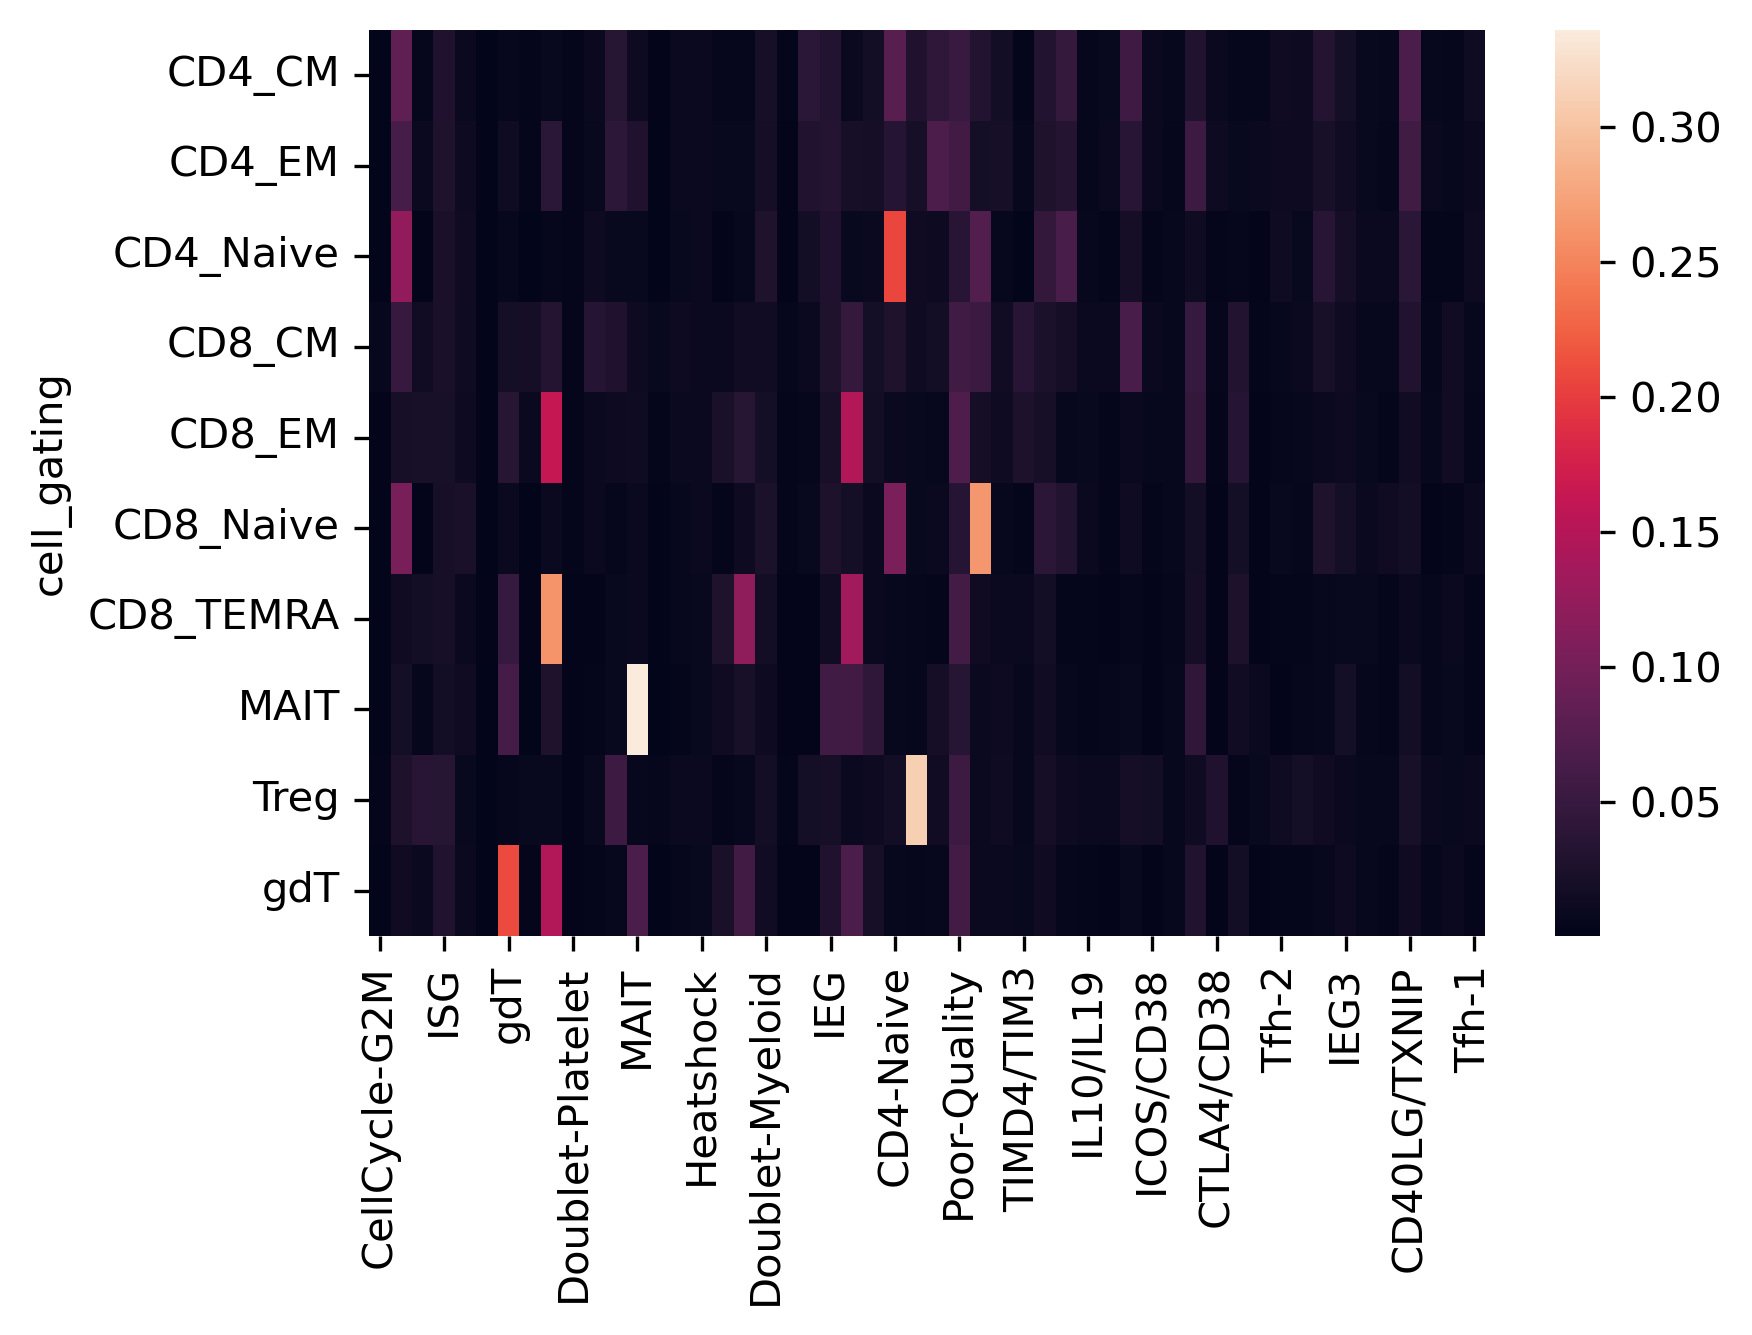

In [15]:
fig, ax = plt.subplots(dpi = 300)
sns.heatmap(dat, ax = ax)

In [16]:
gates_train_all = meta_train_all['cell_gating']
gates_train_all.value_counts().sort_values(ascending = False)

CD4_Naive    115643
CD4_CM        98459
CD4_EM        41023
CD8_TEMRA     36720
CD8_EM        33158
CD8_Naive     25481
Treg          11745
CD8_CM         9694
gdT            6160
MAIT           6042
Name: cell_gating, dtype: int64

In [17]:
gates_train_all.unique()

array(['CD4_CM', 'CD4_Naive', 'CD8_EM', 'Treg', 'CD4_EM', 'gdT',
       'CD8_TEMRA', 'CD8_Naive', 'MAIT', 'CD8_CM'], dtype=object)

In [18]:
scaler_tcat = StandardScaler()
usage_train_all_scaled = scaler_tcat.fit_transform(usage_train_all)
usage_train_all_scaled = pd.DataFrame(usage_train_all_scaled, index=usage_train_all.index, columns=usage_train_all.columns)

train_usage, test_usage, train_gates, test_gates = train_test_split(usage_train_all_scaled, 
                                                                    gates_train_all, 
                                                                    test_size=0.25, random_state=2)

model_tcat = LogisticRegression(solver='lbfgs', random_state=8,
                           multi_class = 'multinomial', class_weight = 'balanced', max_iter=500)
model_tcat.fit(train_usage, train_gates)

pred_tcat = model_tcat.predict(test_usage)
pred_tcat = pd.Series(pred_tcat, index = test_usage.index)
lr_probs_tcat = model_tcat.predict_proba(test_usage)
lr_probs_tcat = pd.DataFrame(lr_probs_tcat, columns=model_tcat.classes_)

(pred_tcat==test_gates).value_counts()

True     27126
False    11287
dtype: int64

In [19]:
vc = (pred_tcat==test_gates).value_counts()
vc / vc.sum()

True     0.706167
False    0.293833
dtype: float64

In [20]:
model_tcat

LogisticRegression(class_weight='balanced', max_iter=500,
                   multi_class='multinomial', random_state=8)

In [21]:
outfn = os.path.join(test_dir, 'model_TCAT_MultinomialLogisticRegression.20240422.pkl')
outfn

'/data/srlab1/TCAT/Data/PerDataset/Sparks2023/model_TCAT_MultinomialLogisticRegression.20240422.pkl'

In [22]:
import pickle
with open(outfn, 'wb') as f:
    # Dump the object into the pickle file
    pickle.dump(model_tcat, f)

In [23]:
usage_train_all.shape

(384125, 52)

In [24]:
scaler_yasumizu = StandardScaler()
yasumizu_usage_train_all_scaled = scaler_yasumizu.fit_transform(yasumizu_usage_norm)
yasumizu_usage_train_all_scaled = pd.DataFrame(yasumizu_usage_train_all_scaled, index=yasumizu_usage_norm.index, columns=yasumizu_usage_norm.columns)

train_usage, test_usage, train_gates, test_gates = train_test_split(yasumizu_usage_train_all_scaled, 
                                                                    gates_train_all, 
                                                                    test_size=0.25, random_state=2)

model_yasumizu = LogisticRegression(solver='lbfgs', random_state=14,
                           multi_class = 'multinomial', class_weight  = 'balanced', max_iter=500)
model_yasumizu.fit(train_usage, train_gates)

pred_yasumizu = model_yasumizu.predict(test_usage)
pred_yasumizu = pd.Series(pred_yasumizu, index = test_usage.index)
lr_probs_yasumizu = model_yasumizu.predict_proba(test_usage)
lr_probs_yasumizu = pd.DataFrame(lr_probs_yasumizu, columns=model_yasumizu.classes_)
(pred_yasumizu==test_gates).value_counts()

True     55050
False    40982
dtype: int64

In [25]:
coef_tcat = pd.DataFrame(model_tcat.coef_, index = model_tcat.classes_, 
                    columns = usage_train_all_scaled.columns)

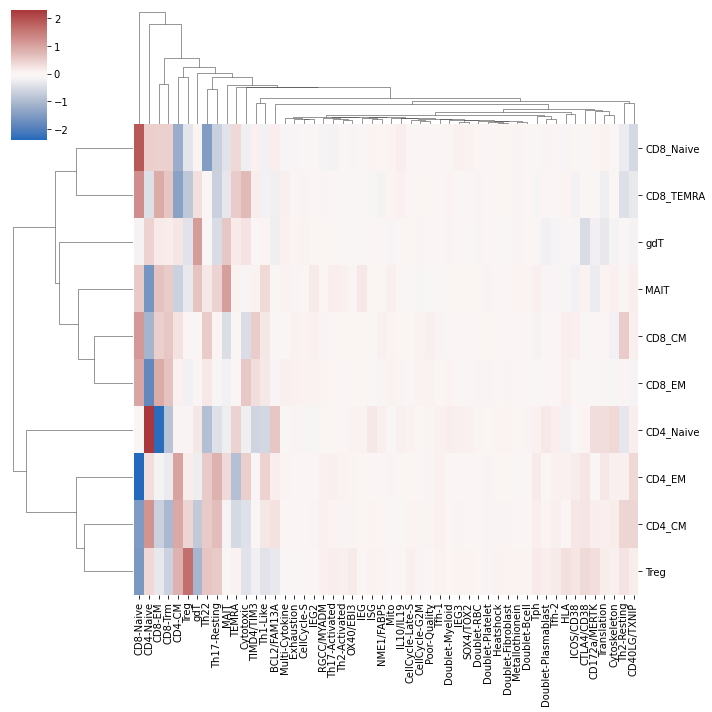

In [26]:
sns.clustermap(coef_tcat, cmap = 'vlag', xticklabels=True)

In [27]:
coef_yasumizu = pd.DataFrame(model_yasumizu.coef_, index = model_yasumizu.classes_, 
                    columns = yasumizu_usage_norm.columns)

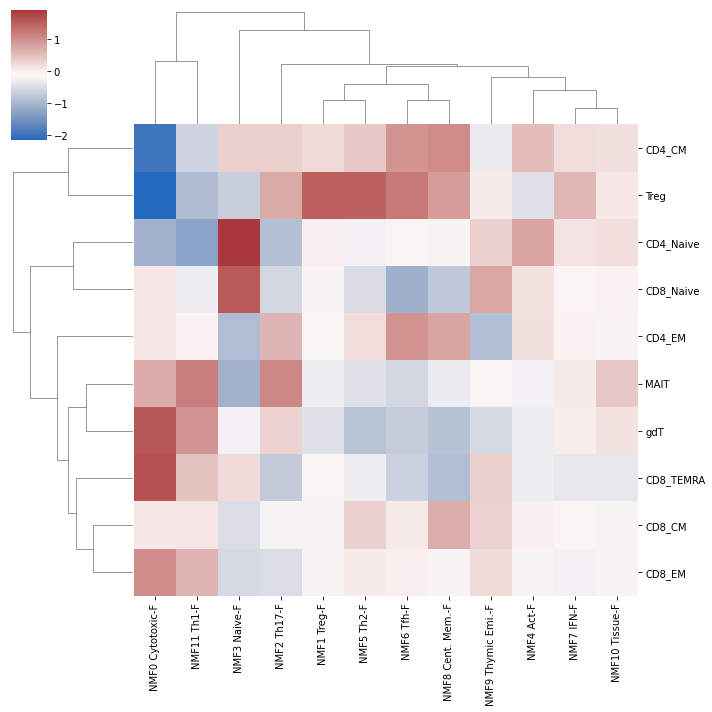

In [28]:
sns.clustermap(coef_yasumizu, cmap = 'vlag')

In [30]:
pred_tcat

CGAGCACAGCTATGCT-1-gPlexB4         Treg
ACATACGCACTGTCGG-1-gPlexB2    CD4_Naive
TGCGCAGAGGCCCGTT-1-gPlexH6       CD4_CM
TGCCCTAGTGGGTCAA-1-gPlexE2    CD4_Naive
AACTGGTGTTCTGTTT-1-gPlexJ5       CD4_EM
                                ...    
TCCACACGTCGGCACT-1-gPlexC5    CD4_Naive
TGAGCATGTCCGAACC-1-gPlexK7    CD8_TEMRA
GCCTCTAAGTAAGTAC-1-gPlexB5    CD4_Naive
GTACTCCTCTGCGGCA-1-gPlexF2    CD4_Naive
TAGAGCTAGCGACGTA-1-gPlexJ7       CD8_EM
Length: 38413, dtype: object

In [ ]:
for gate_type in gate_list_all:
    print(gate_type)
    ind = test_gates[test_gates==gate_type].index
    display((pred_tcat[ind]==gate_type).value_counts())

In [ ]:
(fig,axes) = plt.subplots(2, 5, figsize=(9,4), dpi=200, gridspec_kw={'hspace':.5, 'wspace':.5})
axes = axes.ravel()

for i,gate_type in enumerate(gates_train_all.unique()):
    this_ax = axes[i]
    
    fpr, tpr, _ = roc_curve(test_gates==gate_type, lr_probs_tcat[gate_type])
    auc = roc_auc_score(test_gates==gate_type, lr_probs_tcat[gate_type])

    this_ax.plot(fpr, tpr, marker='.', label='Multinomial')
    
    if i in [0,4]:
        this_ax.set_ylabel('True Positive Rate', fontsize=6)

    if i in [4, 5, 6, 7]:
        this_ax.set_xlabel('False Positive Rate', fontsize=6)
        
    this_ax.text(.2, 0, 'AUC: %.3f' % auc)
    this_ax.set_title('TCAT ' + gate_type, fontsize=6)
    this_ax.tick_params(labelsize=6)

In [ ]:
(fig,axes) = plt.subplots(2, 5, figsize=(9,4), dpi=200, gridspec_kw={'hspace':.5, 'wspace':.5})
axes = axes.ravel()

for i,gate_type in enumerate(gates_train_all.unique()):
    this_ax = axes[i]
    
    fpr, tpr, _ = roc_curve(test_gates==gate_type, lr_probs_yasumizu[gate_type])
    auc = roc_auc_score(test_gates==gate_type, lr_probs_yasumizu[gate_type])

    this_ax.plot(fpr, tpr, marker='.', label='Multinomial')
    
    if i in [0,4]:
        this_ax.set_ylabel('True Positive Rate', fontsize=6)

    if i in [4, 5, 6, 7]:
        this_ax.set_xlabel('False Positive Rate', fontsize=6)
        
    this_ax.text(.2, 0, 'AUC: %.3f' % auc)
    this_ax.set_title('Yasumizu ' + gate_type, fontsize=6)
    this_ax.tick_params(labelsize=6)

## Testing

In [ ]:
dataset = 'Sparks'

gating = pd.read_csv(params.loc[dataset, 'manual_gating_fn'], index_col = 0, sep = '\t',
                     header=0, names = ['cell_gating'])

meta = pd.read_csv(params.loc[dataset, 'metadata_fn'], index_col = 0, sep = '\t')
meta['cell_gating'] = gating.loc[meta.index, 'cell_gating']

gates_to_exclude = ['CD4_TEMRA', 'DN', 'DP']
meta = meta.loc[~meta['cell_gating'].isin(gates_to_exclude), :]


usage = pd.read_csv(params.loc[dataset, 'tcat_fn'], index_col = 0, sep = '\t')
usage.columns = usage.columns.map(rename_map)
usage_norm = usage.div(usage.sum(axis=1), axis=0)

overlap = list(set(usage_norm.index).intersection(meta.index))
meta_test_all = meta.loc[overlap, ]
usage_test_all = usage_norm.loc[overlap, ]
gates_test_all = meta_test_all['cell_gating']

In [ ]:
usage_test_all.head()

In [ ]:
usage_train_all.head()

In [ ]:
yasumizu_usage_sparks = pd.read_csv('../../../Data/PerDataset/Sparks2023/Yasumizu_NMFproject_Usage_TPMscale.tsv', sep='\t', index_col=0)
yasumizu_usage_sparks = yasumizu_usage_sparks.loc[meta_test_all.index, :]
yasumizu_usage_sparks_norm = yasumizu_usage_sparks.div(yasumizu_usage_sparks.sum(axis=1), axis=0)

In [ ]:
#usage_test_all_scaled = scaler.transform(usage_test_all[lineage_geps])
usage_test_all_scaled = scaler_tcat.transform(usage_test_all)
usage_test_all_scaled = pd.DataFrame(usage_test_all_scaled, index=usage_test_all.index,
                                     columns=usage_test_all.columns)
yasumizu_usage_sparks_norm_scaled = scaler_yasumizu.transform(yasumizu_usage_sparks_norm)
yasumizu_usage_sparks_norm_scaled = pd.DataFrame(yasumizu_usage_sparks_norm_scaled,
                                                 index=yasumizu_usage_sparks_norm.index,
                                                 columns=yasumizu_usage_sparks_norm.columns)

In [ ]:
pred_test_tcat = model_tcat.predict(usage_test_all_scaled)
pred_test_tcat = pd.Series(pred_test_tcat, index = usage_test_all_scaled.index)
lr_probs_test_tcat = model_tcat.predict_proba(usage_test_all_scaled)

pred_test_yazumizu = model_yasumizu.predict(yasumizu_usage_sparks_norm_scaled)
pred_test_yazumizu = pd.Series(pred_test_yazumizu, index = yasumizu_usage_sparks_norm_scaled.index)
lr_probs_test_yazumizu = model_yasumizu.predict_proba(yasumizu_usage_sparks_norm_scaled)


In [ ]:
(pred_test_tcat==gates_test_all).value_counts()

In [ ]:
(pred_test_yazumizu==gates_test_all).value_counts()

In [ ]:
nrow = 2
ncol = 5
(fig,axes) = plt.subplots(2, 5, figsize=(9,4), dpi=200, gridspec_kw={'hspace':.5, 'wspace':.5})

roc_test_tcat = pd.DataFrame(columns = ['gate', 'sensitivity', 'specificity'])
auc_test_tcat = pd.DataFrame(columns = ['gate', 'auc'])
pred_roc_tcat = pd.DataFrame(columns = ['gate', 'sensitivity', 'specificity', 'accuracy'])

for n, gate_type in enumerate(model_tcat.classes_):
    j = (n)%ncol
    k = (n)//ncol
    ax = axes[k, j]
    ax.set_title(gate_type, fontsize=10)
    
    
    if j == 0:
        ax.set_ylabel('True Positive Rate', fontsize=6)

    if k ==1:
        ax.set_xlabel('False Positive Rate', fontsize=6)
    
    print(gate_type)
    lr_probs_gate = lr_probs_test_tcat[:, n]
    lr_auc = roc_auc_score(gates_test_all==gate_type, lr_probs_gate)
    lr_fpr, lr_tpr, _ = roc_curve(gates_test_all==gate_type, lr_probs_gate)
    fpr_pred, tpr_pred, _ = metrics.roc_curve(gates_test_all==gate_type, 
                                              pred_test_tcat==gate_type, pos_label = True) 
    accuracy = metrics.balanced_accuracy_score(gates_test_all==gate_type, pred_test_tcat==gate_type)
    auc_test_tcat = auc_test_tcat.append(pd.Series([gate_type, lr_auc], 
                                     index=auc_test_tcat.columns), ignore_index=True)
    roc_test_tcat = pd.concat([roc_test_tcat, pd.DataFrame(dict(zip(roc_test_tcat.columns, [gate_type, 
                                                              lr_tpr, 1-lr_fpr])))])
    pred_roc_tcat = pd.concat([pred_roc_tcat, pd.DataFrame(dict(zip(pred_roc_tcat.columns, 
                                              [gate_type, tpr_pred[1], (1-fpr_pred)[1], accuracy])),
                                                index = [gate_type])])


    ax.plot(lr_fpr, lr_tpr, marker='.', label='TCAT', color='b')
    ax.scatter(x = fpr_pred[1], y = tpr_pred[1], color = 'k', zorder = 3)

    ax.text(.15, 0, 'AUC: %.3f' % lr_auc)
    # # plt.legend()
    
plt.suptitle('TCAT')


In [ ]:
nrow = 2
ncol = 5
(fig,axes) = plt.subplots(2, 5, figsize=(9,4), dpi=200, gridspec_kw={'hspace':.5, 'wspace':.5})

roc_test_yasumizu = pd.DataFrame(columns = ['gate', 'sensitivity', 'specificity'])
auc_test_yasumizu = pd.DataFrame(columns = ['gate', 'auc'])
pred_roc_yasumizu = pd.DataFrame(columns = ['gate', 'sensitivity', 'specificity', 'accuracy'])

for n, gate_type in enumerate(model_yasumizu.classes_):
    j = (n)%ncol
    k = (n)//ncol
    ax = axes[k, j]
    ax.set_title(gate_type, fontsize=10)

    if j == 0:
        ax.set_ylabel('True Positive Rate', fontsize=6)

    if k ==1:
        ax.set_xlabel('False Positive Rate', fontsize=6)

    print(gate_type)
    lr_probs_gate = lr_probs_test_yazumizu[:, n]
    lr_auc = roc_auc_score(gates_test_all==gate_type, lr_probs_gate)
    lr_fpr, lr_tpr, _ = roc_curve(gates_test_all==gate_type, lr_probs_gate)
    fpr_pred, tpr_pred, _ = metrics.roc_curve(gates_test_all==gate_type, 
                                              pred_test_yazumizu==gate_type, pos_label = True) 
    accuracy = metrics.balanced_accuracy_score(gates_test_all==gate_type, pred_test_yazumizu==gate_type)
    auc_test_yasumizu = auc_test_yasumizu.append(pd.Series([gate_type, lr_auc], 
                                     index=auc_test_yasumizu.columns), ignore_index=True)
    roc_test_yasumizu = pd.concat([roc_test_yasumizu, pd.DataFrame(dict(zip(roc_test_yasumizu.columns, [gate_type, 
                                                              lr_tpr, 1-lr_fpr])))])
    pred_roc_yasumizu = pd.concat([pred_roc_yasumizu, pd.DataFrame(dict(zip(pred_roc_yasumizu.columns, 
                                              [gate_type, tpr_pred[1], (1-fpr_pred)[1], accuracy])),
                                                index = [gate_type])])


    ax.plot(lr_fpr, lr_tpr, marker='.', label='Yasumizu', color='b')
    ax.scatter(x = fpr_pred[1], y = tpr_pred[1], color = 'k', zorder = 3)

    ax.text(.15, 0, 'AUC: %.3f' % lr_auc)
    # # plt.legend()
    
    
plt.suptitle('Yasumizu')



In [ ]:
nrow = 2
ncol = 5
(fig,axes) = plt.subplots(2, 5, figsize=(9,4), dpi=200, gridspec_kw={'hspace':.5, 'wspace':.5})

for n, gate_type in enumerate(model_tcat.classes_):
    j = (n)%ncol
    k = (n)//ncol
    ax = axes[k, j]
    ax.set_title(gate_type, fontsize=10)
    
    
    if j == 0:
        ax.set_ylabel('True Positive Rate', fontsize=6)

    if k ==1:
        ax.set_xlabel('False Positive Rate', fontsize=6)
    
    
    
    print(gate_type)
    ind = roc_test_tcat['gate']==gate_type
    ax.plot(1-roc_test_tcat.loc[ind, 'specificity'],
            roc_test_tcat.loc[ind, 'sensitivity'],
            marker='.', label='TCAT', color='orange')
    
    ax.scatter(x = 1-pred_roc_tcat.loc[gate_type, 'specificity'],
               y = pred_roc_tcat.loc[gate_type, 'sensitivity'], color = 'k', zorder = 3)

    ax.text(.1, .1, 'TCAT AUC: %.3f' % auc_test_tcat.loc[auc_test_tcat['gate']==gate_type, 'auc'].iloc[0],
            color='orange', fontsize=6)

    ind = roc_test_yasumizu['gate']==gate_type
    ax.plot(1-roc_test_yasumizu.loc[ind, 'specificity'],
            roc_test_yasumizu.loc[ind, 'sensitivity'],
            marker='.', label='Yasumizu', color='blue')
    
    
    
    ax.scatter(x = 1-pred_roc_yasumizu.loc[gate_type, 'specificity'],
               y = pred_roc_yasumizu.loc[gate_type, 'sensitivity'], color = 'k', zorder = 3)

    ax.text(.1, 0, 'Yasumizu AUC: %.3f' % auc_test_yasumizu.loc[auc_test_yasumizu['gate']==gate_type, 'auc'].iloc[0],
            color='blue', fontsize=6)   

    
    
    
    


In [ ]:
paths = {}

paths.update({
        'roc_TCAT_MultinomialLogisticRegression' : os.path.join(test_dir, 'ROC_TCAT_MultinomialLogisticRegression.tsv'),
        'auc_TCAT_MultinomialLogisticRegression': os.path.join(test_dir, 'AUC_TCAT_MultinomialLogisticRegression.tsv'),
        'pred_TCAT_MultinomialLogisticRegression': os.path.join(test_dir, 'Predictions_TCAT_MultinomialLogisticRegression.tsv'),
        'predroc_TCAT_MultinomialLogisticRegression': os.path.join(test_dir, 'ROCPredictions_TCAT_MultinomialLogisticRegression.tsv'),
        'model_TCAT_MultinomialLogisticRegression': os.path.join(test_dir, 'model_TCAT_MultinomialLogisticRegression.pkl'),
    
    
        'roc_Yasu_MultinomialLogisticRegression' : os.path.join(test_dir, 'ROC_Yasu_MultinomialLogisticRegression.tsv'),
        'auc_Yasu_MultinomialLogisticRegression': os.path.join(test_dir, 'AUC_Yasu_MultinomialLogisticRegression.tsv'),
        'pred_Yasu_MultinomialLogisticRegression': os.path.join(test_dir, 'Predictions_Yasu_MultinomialLogisticRegression.tsv'),
        'predroc_Yasu_MultinomialLogisticRegression': os.path.join(test_dir, 'ROCPredictions_Yasu_MultinomialLogisticRegression.tsv'),    
        'model_Yasu_MultinomialLogisticRegression': os.path.join(test_dir, 'model_Yasu_MultinomialLogisticRegression.pkl'),
    
    
        })
paths

In [ ]:
auc_test_tcat.to_csv(paths['auc_TCAT_MultinomialLogisticRegression'], '\t')
roc_test_tcat.to_csv(paths['roc_TCAT_MultinomialLogisticRegression'], '\t')
pred_test_tcat.to_csv(paths['pred_TCAT_MultinomialLogisticRegression'], '\t')
pred_roc_tcat.to_csv(paths['predroc_TCAT_MultinomialLogisticRegression'], '\t')
joblib.dump({'Scaler':scaler_tcat , 'Multinomial_Predictor':model_tcat}, paths['model_TCAT_MultinomialLogisticRegression'])


auc_test_yasumizu.to_csv(paths['auc_Yasu_MultinomialLogisticRegression'], '\t')
roc_test_yasumizu.to_csv(paths['roc_Yasu_MultinomialLogisticRegression'], '\t')
pred_test_yazumizu.to_csv(paths['pred_Yasu_MultinomialLogisticRegression'], '\t')
pred_roc_yasumizu.to_csv(paths['predroc_Yasu_MultinomialLogisticRegression'], '\t')
joblib.dump({'Scaler':scaler_yasumizu , 'Multinomial_Predictor':model_yasumizu}, paths['model_Yasu_MultinomialLogisticRegression'])
